# Sensitivity check for calculation of AAD from hazard return period maps

In this code, we (qualitatively) examine how sensitive the estimation of annual average displacement (AAD) values are (impact.aai_agg) depending on which hazard RP maps that were included. We perform the analysis for floods in 2 countries (PHL, SOM)

In [1]:
# Load country BEM as prep
from climada.util.constants import SYSTEM_DIR
from climada.hazard import TropCyclone, Hazard
from climada.entity.exposures import Exposures
from climada.engine import ImpactCalc
import numpy as np
import os
import copy
from pathlib import Path

os.chdir('/cluster/project/climate/meilers/scripts/displacement/global-displacement-risk') 
import exposure
import vulnerability
import coastal_flood_hazard

# select country here
cntry = 'Somalia'

In [2]:
gdf_bem_subcomps = exposure.gdf_from_bem_subcomps(cntry, opt='full')# filter and apply impf id
gdf_bem_subcomps = gdf_bem_subcomps[gdf_bem_subcomps.valhum>0.001] # filter out rows with basically no population
gdf_bem_subcomps['impf_FL'] = gdf_bem_subcomps.apply(lambda row: vulnerability.DICT_PAGER_FLIMPF_CIMA[row.se_seismo], axis=1)

for col in ['iso3', 'sector', 'valfis']:
    gdf_bem_subcomps.pop(col)

exp = Exposures(gdf_bem_subcomps)
exp.gdf.rename({'valhum': 'value'}, axis=1, inplace=True)
exp.value_unit = 'Pop. count'
exp.gdf['longitude'] = exp.gdf.geometry.x
exp.gdf['latitude'] = exp.gdf.geometry.y
exp.gdf = exp.gdf[~np.isnan(
    exp.gdf.latitude)]  # drop nan centroids

### Load CIMA flood hazard (river)

In [9]:
HAZ_FOLDER = Path(f'/cluster/work/climate/evelynm/IDMC_UNU/hazard/flood_HM_CIMA/{cntry}/HISTORICAL/')
HAZ_TYPE = 'FL'

haz_files = np.sort([str(file) for file in HAZ_FOLDER.glob('*.tif')])
rp = np.sort(np.array([int(Path(file).stem[-4:]) for file in haz_files]))

Create a dictionary (haz_dict) where each key is a number from 1 to 9 (representing the count of RPs and files) and each value is a Hazard object created using progressively more elements from haz_files and rp up to that number.

In [11]:
haz_dict = {}
for i in range(1, 10):
    files_slice = haz_files[:i]
    rp_slice = rp[:i]

    # Create the Hazard object
    haz = Hazard.from_raster(
        haz_type=HAZ_TYPE,
        files_intensity=list(files_slice),
        src_crs='WGS84',
        attrs={
            'unit': 'm',
            'event_id': np.arange(len(files_slice)),
            'frequency': 1 / rp_slice
        }
    )
    haz.intensity = haz.intensity/100
    haz_dict[i] = haz

### Caluclate impacts

#### CIMA/Capra impact functions

In [12]:
impf_set_cima = vulnerability.IMPF_SET_FL_CIMA

In [13]:
from climada.entity import ImpactFunc, ImpactFuncSet
impf_set_cima_step = ImpactFuncSet()

In [14]:
# The threshold of building damage after which all people are displaced. Below, no-one is displaced.
building_thes = 0.3 # 55% iDMC v1; CIMA: 30% for Somalia to 60% for other countries. 

for imp_id in impf_set_cima.get_ids(haz_type='FL'):
    impf_set_cima.get_func(fun_id=imp_id)
    y = impf_set_cima.get_func(fun_id=imp_id)[0].intensity
    x = impf_set_cima.get_func(fun_id=imp_id)[0].mdd
    flood_thres = np.interp(building_thes, x, y)
    impf_set_cima_step.append(
                ImpactFunc.from_step_impf(
                    intensity=(0,  flood_thres, flood_thres *10),
                    haz_type='FL',
                    impf_id=imp_id,
                    intensity_unit = 'm'
                )
    )

ID: 1 - threshold stepfunction: 1.6501727272727271
ID: 2 - threshold stepfunction: 3.0897
ID: 3 - threshold stepfunction: 5.8621
ID: 4 - threshold stepfunction: 7.25308813559322
ID: 5 - threshold stepfunction: 10.0
ID: 6 - threshold stepfunction: 1.6494416666666667
ID: 7 - threshold stepfunction: 2.8966
ID: 8 - threshold stepfunction: 4.4510233333333336
ID: 9 - threshold stepfunction: 5.833358333333334
ID: 10 - threshold stepfunction: 7.2498097560975605
ID: 11 - threshold stepfunction: 1.0249714285714286
ID: 12 - threshold stepfunction: 0.7434042553191489
ID: 13 - threshold stepfunction: 0.7436553191489361
ID: 14 - threshold stepfunction: 1.0249714285714286
ID: 15 - threshold stepfunction: 1.4075205479452055


In [16]:
aai_agg_dict = {}
for n, haz in haz_dict.items():
    impact = ImpactCalc(exp, impf_set_cima_step, haz).impact()
    aai_agg_dict[n] = impact.aai_agg

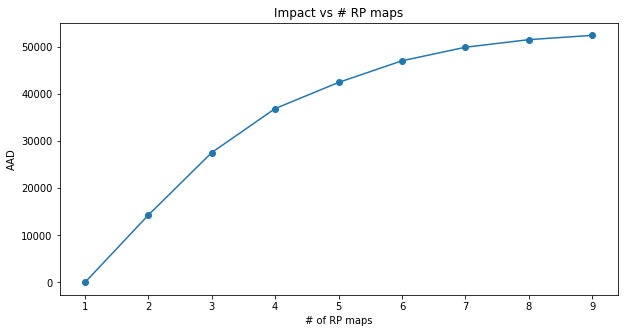

In [19]:
import matplotlib.pyplot as plt

RPs = list(aai_agg_dict.keys())
impacts = list(aai_agg_dict.values())

plt.figure(figsize=(10, 5))
plt.plot(RPs, impacts, marker='o')
plt.title('Impact vs # RP maps')
plt.xlabel('# of RP maps')
plt.ylabel('AAD')
plt.show()

In [20]:
aai_agg_dict

{1: 0.0,
 2: 14307.27784673741,
 3: 27588.561086471127,
 4: 36933.87399063758,
 5: 42486.14860083056,
 6: 47081.49006567723,
 7: 49961.74650385818,
 8: 51569.828748638,
 9: 52485.36424177725}

In [41]:
imp = []
for n in range(0,9):
    imp.append(impact.at_event[n]*impact.frequency[n])

In [45]:
imp

[0.0,
 14307.277846737408,
 13281.283239733719,
 9345.312904166463,
 5552.274610192963,
 4595.34146484671,
 2880.2564381808693,
 1608.0822447799073,
 915.5354931392578]

In [44]:
sum(imp)

52485.3642417773

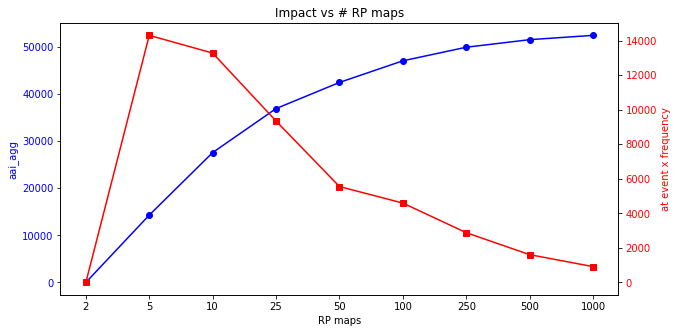

In [55]:
plt.figure(figsize=(10, 5))

# Creating the first plot
ax1 = plt.gca()  # Gets the current axis
ax1.plot(RPs, impacts, marker='o', color='b', label='Impacts')  # Plot the impacts on the primary y-axis
ax1.set_xlabel('RP maps')
ax1.set_ylabel('aai_agg', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax1.set_xticks(RPs)  # Set the ticks to be at the positions where the RPs are
ax1.set_xticklabels(rp)  # Set the tick labels to be the RP values, with a rotation for better visibility

# Creating the secondary y-axis
ax2 = ax1.twinx()  # Creates a second y-axis sharing the same x-axis
ax2.plot(RPs, imp, marker='s', color='r', label='Additional Metric')  # Plot 'imp' on the secondary y-axis
ax2.set_ylabel('at event x frequency', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Title and legends
plt.title('Impact vs # RP maps')
fig = plt.gcf()

plt.show()